## Import Liberaries

In [1]:
# dataframe, plotting and wrangling
import pandas as pd
import datetime
from datetime import datetime
from datetime import date, timedelta
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pickle
from scipy import sparse
from collections import Counter
import itertools
from random import sample
import scipy
from scipy import stats
from scipy.stats import chi2_contingency

#import NLP liberaries:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re

#ML from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier 
from xgboost import XGBClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#TF and Keras for neural net:
import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense
from keras.models import model_from_json

Using TensorFlow backend.


## Functions

In [2]:
# iunput a dataframe and outputs an one-hot-encoded array and corresponding columns for it
def OHE(df):
    # selecting important features
    df = df[['type','subtype','pipe_type', 'system']]
    x = np.asarray(df)
    columns = []
    encoded_x = None
    for i in range(0, x.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(x[:,i])
        feature = feature.reshape(x.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        feature = onehot_encoder.fit_transform(feature)
        if encoded_x is None:
            encoded_x = feature
        else:
                encoded_x = np.concatenate((encoded_x, feature), axis=1)
        columns.extend([df_ml.columns[i]]*feature.shape[1])
    return(encoded_x, columns)

#plots a neat confusion matrix
def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

# NLP preproccing       
def text_cleaner(text):
    txt = []
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    text_ = [re.sub('\d', ' ', x) for x in text]
    for i in range(len(text)):
        temp = text_[i]
        temp = temp.strip().lower()
        cleaned = re.sub('\W+', ' ', temp)
        tokenized = word_tokenize(cleaned)
        filtered = [word for word in tokenized if word not in stop_words]
        lemmatized = [lemmatizer.lemmatize(token) for token in filtered]
        string = TreebankWordDetokenizer().detokenize(lemmatized)
        txt.append(string)
    return(txt)

#removes names of companies from regulators' notes so that model cannot cheat based on that!
def cheat_stopper(df, txt):
    name = list(df.name)
    notes = []
    for i in range(len(txt)):
        name_tokens = word_tokenize(name[i])
        review_tokens = word_tokenize(txt[i])
        note = [word for word in review_tokens if word not in name_tokens]
        string = TreebankWordDetokenizer().detokenize(note)
        notes.append(string)   
    return(notes)

# this function merge the child company names to their main company
# for example 'Kinder Morgan North Carolina llp.' and 'Kiner Morgan Texas Refineries' both change to 'Kinder Morgan'
def name_cleaner(df):
    companies = [ 'williams ','western refining','vintage ', 'valero','unocal ','union oil','ugi ','torrance ','tesoro' ,'teppco ','targa ','sunoco ','shell ','public service ','plains ','phillips ','peoples ','oryx ','oneok ','nustar ','northern states power','national fuel','mustang ','mobil ','midcoast ','mid-continent','mid - valley', 'markwest ', 'marathon ', 'magellan','lone star', 'liberty ', 'genesis ', 'harvest', 'ldh energy', 'kinetica ', 'koch ', 'keyspan ', 'kinder morgan', 'interstate ', 'gulf ', 'great lakes', 'enable gas ', 'exxonmobil ', 'equistar ', 'express ', 'entergy ', 'energy xxi', 'enron ', 'enlink ', 'enbridge ', 'dow pipeline','duke energy', 'consumers ''alliant energy', 'bridger ', 'dominion energy', 'denbury ', 'corning ', 'delek ', 'chesapeake ', 'consolidated edison', 'centerpoint energy', 'columbia gas ', 'chevron ', 'conocophillips ', 'buckeye ', 'citgo ', 'colonial ', 'citizens ', 'bridgeline ', 'american midstream', 'amoco ', 'aquila ', 'atmos energy', 'avista ', 'boardwalk ', 'bp ', 'bridgeline ']
    df['name'] = df['name'].apply(lambda x: x.lower() if type(x)== str else x)
    for word in companies:
        df['name'] =  df['name'].apply(lambda x: word if type(x)==str and word in x else x)
    return df

## EDA

### Aggregated mileage and tanks

In [3]:
#creating a cleaned dataframe having the name and aggregates mileage and tanks:
df_mileage = pd.read_csv(r'E:\Data\Canmet\ML\pipeline\milage.csv', encoding = "ISO-8859-1")
df_mileage = df_mileage[['name', 'miles', 'tanks']]
df_mileage = df_mileage.fillna('nan')
df_mileage = df_mileage[(df_mileage.name != 'nan')]
df_mileage.reset_index(drop=True, inplace=True)
df_mileage['miles'] = df_mileage['miles'].apply(lambda x: 0 if type(x)!= float else x)
#merge child and parents and aggregate:
df_mileage = name_cleaner(df_mileage)
df_mileage = df_mileage.groupby(['name']).agg(['sum']).reset_index()
df_mileage.columns =['name', 'miles', 'tanks']
df_mileage = df_mileage.sort_values('miles', ascending = False).reset_index(drop=True)
df_mileage.head()

,name,miles,tanks
0,enterprise products operating llc,21970.0,244
1,magellan,12983.0,890
2,oneok,11792.0,35
3,phillips,11580.0,380
4,plains,10160.0,473


### Correlation of number of tank and mileage

Text(0, 0.5, 'Number of tanks')

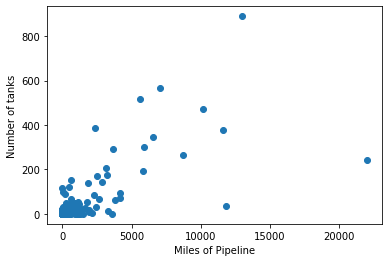

In [4]:
plt.scatter(df_mileage['miles'], df_mileage['tanks'])
plt.xlabel('Miles of Pipeline')
plt.ylabel('Number of tanks')

### Sum of lost barrels lost and count of incidents aggregated

In [13]:
#creating and cleaning a dataframe of causes of incidents where system is crude oil:
df_all_systems = pd.read_csv(r'E:\Data\Canmet\ML\pipeline\all_us.csv', encoding = "ISO-8859-1")
df_all_systems.rename(columns={'Reported Cause of Incident': 'cause', 'Operator Name': 'name', 'cause_sub ': 'cause_sub', 'System Type': 'system', 'Fatalities': 'fatal', 'Total Cost Current Year Dollars': 'cost'}, inplace=True)
df_all_systems = df_all_systems.drop(['Cost_Reported', 'Report ID', 'Operator ID', 'County'], axis = 1)
df_crude = df_all_systems[(df_all_systems.system == 'HAZARDOUS LIQUID')]
df_crude = name_cleaner(df_crude)
df_agg = df_crude[['name', 'b_lost']].groupby(['name']).agg([ 'count', 'sum' ]).reset_index()
df_agg.columns =['name',  'count', 'sum barrels lost']
df_agg = df_agg.sort_values('count', ascending = False).reset_index(drop=True)
df_agg.head()

,name,count,sum barrels lost
0,magellan,480,29929
1,enterprise crude pipeline llc,392,21539
2,sunoco,391,19822
3,plains,377,10044
4,phillips,348,92781


In [11]:
# merging the mileage info with failures and creating a risk index:
df_all = pd.merge(df_mileage,df_agg, left_on = 'name', right_on = 'name')

#remove companies if they too small
df_all = df_all.drop(df_all[df_all['count']<5].index)
df_all['risk_index'] = df_all['sum barrels lost']/df_all['miles']
df_all['index_c'] = df_all['count']/df_all['miles']
df_all = df_all.sort_values('count', ascending = False).reset_index(drop=True)
df_all.head()

,name,miles,tanks,count,sum barrels lost,risk_index,index_c
0,magellan,12983.0,890,480,29929,2.305245,0.036971
1,enterprise crude pipeline llc,3241.0,176,392,21539,6.645788,0.120950
2,sunoco,6554.0,345,391,19822,3.024413,0.059658
3,plains,10160.0,473,377,10044,0.988583,0.037106
4,phillips,11580.0,380,348,92781,8.012176,0.030052


[1, 500, 0, 140]

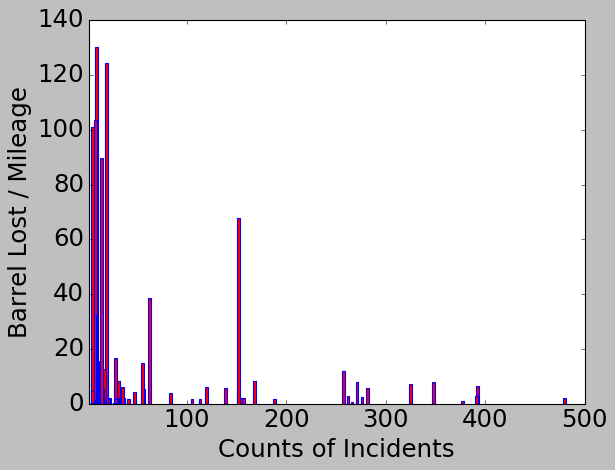

In [23]:
plt.bar(df_all['count'], df_all['risk_index'], width=2.9, color = 'red', edgecolor = 'blue' )
plt.xlabel('Counts of Incidents')
plt.ylabel('Barrel Lost / Mileage')
plt.axis([1, 500, -0, 140])

### Measure correlation between companies and causes 

In [28]:
#chi squar test:
df_chi = df_crude[['name', 'cause']]
df_chi = df_chi.pivot_table(index = 'name', columns= 'cause', aggfunc=np.count_nonzero).reset_index().fillna(0)
df_chi = df_chi[df_chi['name'].isin(names)]
df_chi = df_chi.drop(['name'], axis = 1)
table = np.asarray(df_chi)
stat, p, dof, expected = chi2_contingency(table)
print('p value', p)

p value 4.6701188655266876e-306


### Barrels lost vs Mileage

[-1000, 25000, -4000, 200000]

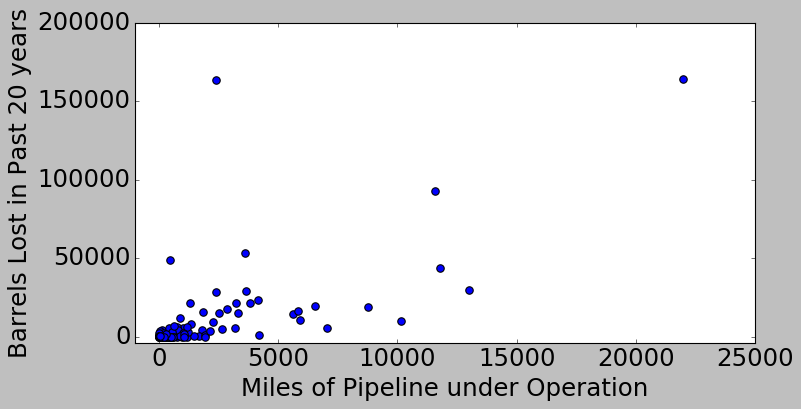

In [31]:
plt.figure(figsize=(10,5), )
plt.xlabel('Miles of Pipeline under Operation')
plt.ylabel('Barrels Lost in Past 20 years')
plt.rcParams.update({'font.size': 22})
plt.scatter(df_all['miles'], df_all['sum barrels lost'], s = 45)
plt.axis([-1000, 25000, -4000, 200000])

### Aggregate over causes

In [8]:
df_crude_agg = df_crude[['cause_sub', 'cost', 'b_lost']].groupby(['cause_sub']).agg([ 'count' ,'sum' ]).reset_index()
df_crude_agg.columns =['cause',  'count', 'cost','countt', 'spilled']
df_crude_agg = df_crude_agg.sort_values('spilled', ascending = False).reset_index(drop=True)
df_crude_agg.head()

,cause,count,cost,countt,spilled
0,THIRD PARTY EXCAVATION DAMAGE,238,167379697,238,183955
1,EXTERNAL,520,547959817,520,122373
2,PIPE SEAM,46,93138678,46,91285
3,MISCELLANEOUS,295,209252218,295,57774
4,ENVIRONMENTAL CRACKING-RELATED,37,1056573952,37,42698


[-10, 710, -60000000, 1100000000.0]

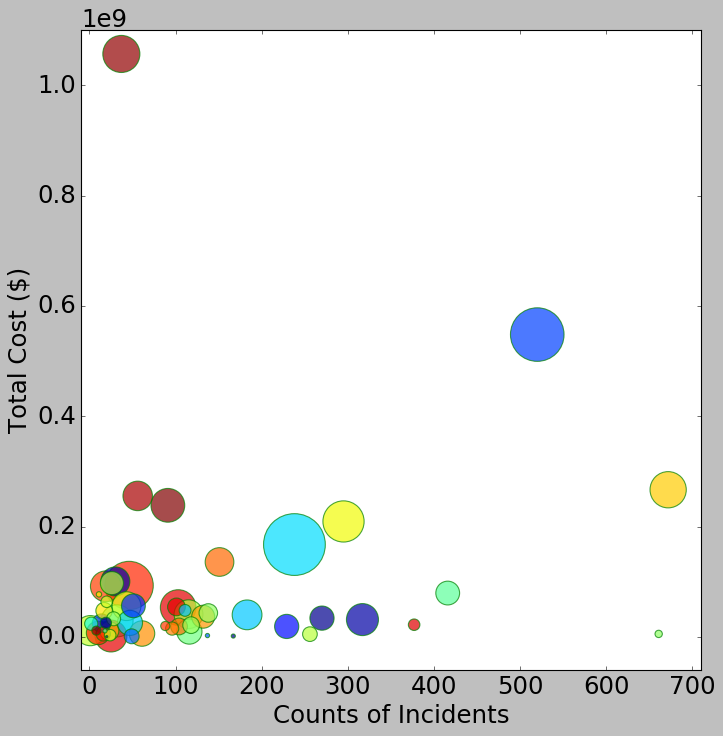

In [32]:
spill = df_crude_agg['spilled']
colors = np.random.rand(55)
plt.figure(figsize=(10,10), )
plt.xlabel('Counts of Incidents')
plt.ylabel('Total Cost ($)')
plt.rcParams.update({'font.size': 24})
plt.scatter(df_crude_agg['count'], df_crude_agg['cost'], s=(spill/1.9)**0.7,  edgecolors='green',c=colors,  alpha=0.7 )
plt.axis([-10, 710, -60000000, 1.1e9])

## Model

### Input and clean dataframe

In [14]:
df_raw = pd.read_csv(r'E:\Data\Canmet\ML\pipeline\crude.csv', encoding = "ISO-8859-1")
df = df_raw.drop([ 'shut_explain', 'mat_details'], axis = 1)

names_original = len(df['name'].unique())
#list of companies with child names:
df = name_cleaner(df)
df = df.fillna('nan')
print(names_original,'number unique company names reduced to', len(df['name'].unique()))
df.head()

297 number unique company names reduced to 199


,name,type,subtype,shut,state,area,area_sub,pipe_type,system,system_sub,item,material,release,function_pipe,op_type,cause,cause_sub,nlp
0,"bkep pipeline, llc",CRUDE OIL,nan,NO,OK,"TANK, INCLUDING ATTACHED APPURTENANCES",nan,INTRASTATE,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",ATMOSPHERIC OR LOW PRESSURE,VALVE,CARBON STEEL,OTHER,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,CONTRACTOR WORKING FOR THE OPERATOR,INCORRECT OPERATION,"VALVE LEFT OR PLACED IN WRONG POSITION, BUT NO...",ACTION ENVIRONMENTAL WAS ON SITE TO CONDUCT RO...
1,kinder morgan,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,"DIESEL, FUEL OIL, KEROSENE, JET FUEL",NO,TX,ABOVEGROUND,TYPICAL ABOVEGROUND FACILITY PIPING OR APPURTE...,INTRASTATE,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,nan,OTHER,CARBON STEEL,LEAK,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,EQUIPMENT FAILURE,THREADED CONNECTION/COUPLING FAILURE,ON 12/04/19 ON OPERATOR FOUND PRODUCT COMING F...
2,colonial,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,GASOLINE (NON-ETHANOL),NO,TX,"TANK, INCLUDING ATTACHED APPURTENANCES",nan,INTERSTATE,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",ATMOSPHERIC OR LOW PRESSURE,TANK/VESSEL,CARBON STEEL,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,EQUIPMENT FAILURE,"FAILURE OF EQUIPMENT BODY (EXCEPT PUMP), TANK ...","ON DECEMBER 4, 2019, A COLONIAL OPERATOR NOTED..."
3,"sfpp, lp",REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,"DIESEL, FUEL OIL, KEROSENE, JET FUEL",YES,CA,UNDERGROUND,UNDER SOIL,INTERSTATE,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,nan,VALVE,CARBON STEEL,LEAK,> 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,OTHER INCIDENT CAUSE,UNKNOWN,THE STATION OPERATOR DISCOVERED A LEAK ON THE ...
4,shell,CRUDE OIL,nan,NO,CA,UNDERGROUND,UNDER SOIL,INTRASTATE,"ONSHORE PIPELINE, INCLUDING VALVE SITES",nan,PIPE,CARBON STEEL,RUPTURE,=< 20% SMYS REGULATED TRUNKLINE/TRANSMISSION,OPERATOR EMPLOYEE,CORROSION FAILURE,EXTERNAL CORROSION,LOPC 8M68 PURGING LINE LEAKS:CREWS WERE IN THE...


### One Hot Encoding Features 

In [15]:
#preparing df for machine learning, low freq companies are dropped out.
df_ml = df
df_ml['cnt']=df.groupby('name')['type'].transform('count')
df_ml = df_ml.drop(df_ml[df_ml.cnt<5].index)

#encoding y
y = np.asarray(df_ml[['name']])
y = y.reshape(len(y),)
label_encoder_y = LabelEncoder()
label_encoder_y = label_encoder_y.fit(y)
encoded_y = label_encoder_y.transform(y)
#pickle.dump(label_encoder_y, open('label_encoder_y.pkl','wb'))
print("y shape: : ", encoded_y.shape)
print('number of companies', len(np.unique(np.hstack(encoded_y))))

#encoding x:
encoded_x, columns = OHE(df_ml)
print("x shape: : ", encoded_x.shape)

y shape: :  (3788,)
number of companies 88
x shape: :  (3788, 24)


### NLP preproccesing

In [16]:
text = list(df_ml['nlp'])
one_text = " ".join(text)
tkn = word_tokenize(one_text)
print("Number of all words: ", len(tkn))
print("Number of unique words: ", len(np.unique(np.hstack(tkn))))

txt = text_cleaner(text)
notes = cheat_stopper(df, txt)
print('all reviews', len(notes))

one_text = " ".join(notes)
tkn = word_tokenize(one_text)
print("Number of all words after cleaning: ", len(tkn))
print("Number of unique words after cleaning: ", len(np.unique(np.hstack(tkn))))

Number of all words:  591953
Number of unique words:  19689
all reviews 3788
Number of all words after cleaning:  300748
Number of unique words after cleaning:  9709


### Text Match

In [41]:
#How much a text matches the most frequent 1000 words of database, this will be used in web-app to avoid non-technical descriptions being fed to the model.
dic = Counter(tkn)
sorted_dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
words = dic.keys()
freq = [word for word in words if dic[word]>44]
#save it for the web-app upload:
pickle.dump(freq, open('used_words.pkl','wb'))
sample_text = 'pipeline corrosion failure steel crude ph size pressure temperature diameter onshore under ground'
cleaned = re.sub('\W+', ' ', sample_text)
tokens = word_tokenize(cleaned)
match = len([token for token in tokens if token in freq])/len(tokens)
print(round(match,2))    

0.77


### Frequency of Words

Text(0, 0.5, 'Frequency of each word')

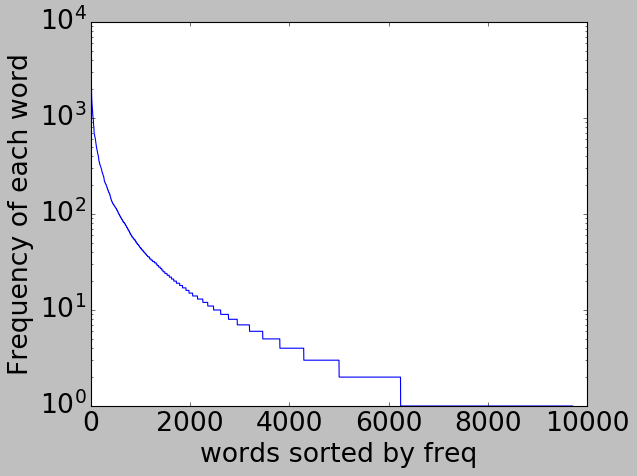

In [42]:
values = dic.values()
values = sorted(values)
plt.plot(list(reversed(range(len(values)))), values)
plt.yscale('log')
plt.xlabel('words sorted by freq')
plt.ylabel('Frequency of each word')

### How it changes technical notes:

In [43]:
i = 2
print(df.cause[i],'===>', df.cause_sub[i],'\n\n', text[i], '\n\n',  notes[i])

EQUIPMENT FAILURE ===> FAILURE OF EQUIPMENT BODY (EXCEPT PUMP), TANK PLATE, OR OTHER MATERIAL 

 ON DECEMBER 4, 2019, A COLONIAL OPERATOR NOTED THAT TANK 1465 MIGHT BE EXPERIENCING A LEAK IN THE TANK FLOOR WITH PRODUCT MIGRATING TOWARDS THE VICINITY OF THE CHINE (BOTTOM EXTENSION). THE CHINE (BOTTOM EXTENSION) IS THE FLAT STEEL PERIMETER FLOOR PLATE, WHICH EXTENDS UNDER THE SHELL AND OUTSIDE OF THE TANK, RESTING ON THE CONCRETE RINGWALL FOUNDATION. UPON FURTHER INVESTIGATION, A GASOLINE LEAK WAS CONFIRMED AT 1710 CENTRAL TIME. IT WAS DETERMINED THAT GASOLINE WAS SEEPING FROM UNDER THE TANK. THE PRODUCT WAS CONTAINED WITHIN THE TANK DIKE. ADDITIONALLY, CONTAINMENT BOOM WAS PLACED WITHIN THE DIKE AREA.    ON DECEMBER 4, 2019, 1804 CENTRAL TIME, A TELEPHONIC NRC REPORT (NRC#1265544) WAS MADE WITH AN ESTIMATED QUANTITY OF 1 BBL. RELEASED. THE NRC REPORT WAS MADE DUE TO THE DETERMINATION THAT ESTIMATED COSTS ASSOCIATED WITH THE RELEASE WOULD EXCEED $50,000.     ON DECEMBER 6, 2019, 1612 CEN

### TFIDF vectorizer

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(notes)
vector = vectorizer.transform(notes)
print(vector.shape)
print(type(vector))
print(vector.toarray())

(3788, 9683)
<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Merging TFIDF and Features as one Sparse Matrix

In [20]:
all_in = np.concatenate([vector.toarray(), encoded_x], axis = 1)
all_features = sparse.csr_matrix(all_in)

#10% of samples is cut for test
test_size = 0.1
seed = 44
# for features and NLP as input use:
x, x_test_final, y, y_test_final = train_test_split(all_features, encoded_y, test_size=test_size, random_state=seed)
#for just notes from regulators use:
x, x_test_final, y, y_test_final = train_test_split(vector, encoded_y, test_size=test_size, random_state=seed)

## Random Forest

In [21]:
test_size = 0.25
# fixing the random state: x_tain should be the same for NN and RF
seed = 44
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,  random_state=seed)

#for loops were used to get to these optimal values for estimators, depth, etc., these are fine tuned now:
n_estimators, max_depths, min_samples_split, min_samples_leaf = [150], [40], [10], [4]

for estimators in n_estimators:   
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                model_rf = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model_rf.fit(x_train, y_train)  
                prediction_train = model_rf.predict(x_train)
                prediction_test = model_rf.predict(x_test)
                print(round(time.time() - start_time,2), 'accuracy train', round(accuracy_score(y_train, prediction_train), 2),
        'accuracy test ', round(accuracy_score(y_test, prediction_test), 2))
                
edu_guess = np.asarray(sample(list(encoded_y),len(y_test)))
edu_guess = edu_guess.reshape(len(y_test),)
print('edu_guess:', round(accuracy_score(y_test, edu_guess), 2))

2.73 accuracy train 0.74 accuracy test  0.5
edu_guess: 0.05


## ANN

Train on 2556 samples, validate on 853 samples
Epoch 1/20
2556/2556 [==============================] - 10s 4ms/step - loss: 3.2887 - accuracy: 0.1960 - val_loss: 3.1124 - val_accuracy: 0.1817
Epoch 2/20
2556/2556 [==============================] - 9s 4ms/step - loss: 2.7880 - accuracy: 0.2782 - val_loss: 2.8092 - val_accuracy: 0.2837
Epoch 3/20
2556/2556 [==============================] - 9s 4ms/step - loss: 2.4323 - accuracy: 0.3775 - val_loss: 2.6303 - val_accuracy: 0.3306
Epoch 4/20
2556/2556 [==============================] - 9s 4ms/step - loss: 2.1176 - accuracy: 0.4652 - val_loss: 2.3531 - val_accuracy: 0.4185
Epoch 5/20
2556/2556 [==============================] - 9s 4ms/step - loss: 1.8096 - accuracy: 0.5426 - val_loss: 2.2108 - val_accuracy: 0.4490
Epoch 6/20
2556/2556 [==============================] - 9s 4ms/step - loss: 1.5862 - accuracy: 0.5974 - val_loss: 2.1288 - val_accuracy: 0.4830
Epoch 7/20
2556/2556 [==============================] - 10s 4ms/step - loss: 1.3554 - ac

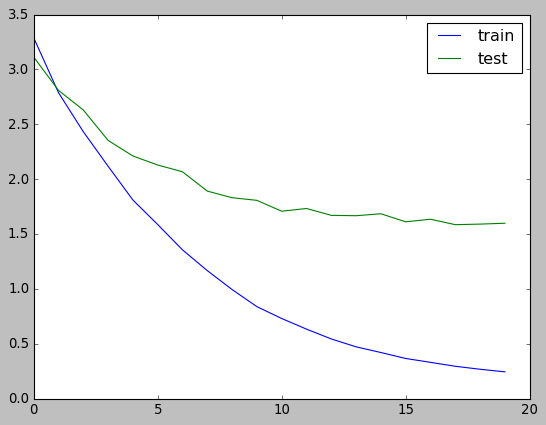

0.1 1000 16 Accuracy: 60.49%


In [24]:
softmax_units = len(np.unique(np.hstack(encoded_y)))
#for loops were used to get to these optimal values for units, lr, epochs, etc:
units = [1000]
epochs = 20
batch_sizes = [16]
lrs = [0.1]

for lr in lrs:
    for unit in units:
        for batch_size in batch_sizes:
            model_nn = Sequential()
            model_nn.add(Dense(units = unit,input_dim = 9707, activation='relu'))
            model_nn.add(Dense(units = softmax_units,  activation='softmax'))
            opt = SGD(lr=lr, momentum=0.9, decay=0.001)
            model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
            history = model_nn.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(x_test, y_test), verbose = 1, shuffle=True)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()
            scores = model_nn.evaluate(x_test, y_test, verbose=0)
            print(lr,unit, batch_size, "Accuracy: %.2f%%" % (scores[1]*100))

## ANN as Ensemble of already trained RF and ANN

### Concating Probabilty Matrixes from ANN and RF

In [25]:
concat = []
for i in range(len(y)):
    concat.append(np.concatenate((model_nn.predict(x[i]), model_rf.predict_proba(x[i])), axis=1))
concat = np.asarray(concat)
concat = np.reshape(concat, (concat.shape[0], concat.shape[2]))
np.shape(concat)

(3409, 176)

### Training the ensemble model

Train on 2556 samples, validate on 853 samples
Epoch 1/40
2556/2556 [==============================] - 1s 458us/step - loss: 1.9725 - accuracy: 0.6275 - val_loss: 1.3174 - val_accuracy: 0.7878
Epoch 2/40
2556/2556 [==============================] - 1s 469us/step - loss: 1.0430 - accuracy: 0.8110 - val_loss: 1.0455 - val_accuracy: 0.8042
Epoch 3/40
2556/2556 [==============================] - 1s 416us/step - loss: 0.8763 - accuracy: 0.8333 - val_loss: 0.9548 - val_accuracy: 0.8124
Epoch 4/40
2556/2556 [==============================] - 1s 329us/step - loss: 0.7882 - accuracy: 0.8415 - val_loss: 0.8928 - val_accuracy: 0.8277
Epoch 5/40
2556/2556 [==============================] - 1s 367us/step - loss: 0.7368 - accuracy: 0.8439 - val_loss: 0.8512 - val_accuracy: 0.8288
Epoch 6/40
2556/2556 [==============================] - 1s 343us/step - loss: 0.6920 - accuracy: 0.8509 - val_loss: 0.8278 - val_accuracy: 0.8312
Epoch 7/40
2556/2556 [==============================] - 1s 259us/step - loss:

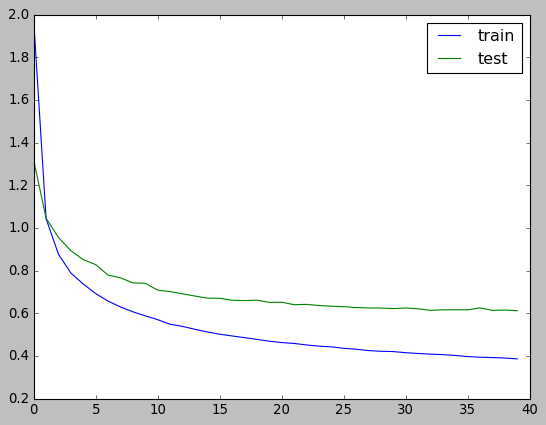

0.1 1000 16 Accuracy: 87.57%


In [26]:
test_size = 0.25
xtrain, xtest, ytrain, ytest = train_test_split(concat, y, test_size=test_size)
model = Sequential()
model.add(Dense(units = unit,input_dim = 176, activation='relu'))
model.add(Dense(units = softmax_units,  activation='softmax'))
#model.compile(optimizer = "adam", loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'], lr = lr)
opt = SGD(lr=lr, momentum=0.9, decay=0.001)
model.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
#model.summary()
history = model.fit(xtrain, ytrain, epochs = 40, batch_size = batch_size, validation_data=(xtest, ytest), verbose = 1, shuffle=True)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
scores = model.evaluate(xtest, ytest, verbose=0)
print(lr,unit, batch_size, "Accuracy: %.2f%%" % (scores[1]*100))

### Accuracy on samples never seen by any of models

In [28]:
concat_final = []
for i in range(len(y_test_final)):
    concat_final.append(np.concatenate((model_nn.predict(x_test_final[i]), model_rf.predict_proba(x_test_final[i])), axis=1))
concat_final = np.asarray(concat_final)
concat_final = np.reshape(concat_final, (concat_final.shape[0], concat_final.shape[2]))
scores = model.evaluate(concat_final, y_test_final, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.75%


### Producing predicted results for confusion matrix

In [30]:
prediction_train = []
for i in range(len(y_train)):
    concat_final = []
    concat_final.append(np.concatenate((model_nn.predict(x_train[i]), model_rf.predict_proba(x_train[i])), axis=1))
    concat_final = np.asarray(concat_final)
    concat_final = np.reshape(concat_final, (concat_final.shape[0], concat_final.shape[2]))
    prediction_train.append(np.argsort(model.predict(concat_final))[:,-1:][0][0])

prediction_test = []
for i in range(len(y_test)):
    concat_final = []
    concat_final.append(np.concatenate((model_nn.predict(x_test[i]), model_rf.predict_proba(x_test[i])), axis=1))
    concat_final = np.asarray(concat_final)
    concat_final = np.reshape(concat_final, (concat_final.shape[0], concat_final.shape[2]))
    prediction_test.append(np.argsort(model.predict(concat_final))[:,-1:][0][0])

prediction_test_final = []
for i in range(len(y_test_final)):
    concat_final = []
    concat_final.append(np.concatenate((model_nn.predict(x_test_final[i]), model_rf.predict_proba(x_test_final[i])), axis=1))
    concat_final = np.asarray(concat_final)
    concat_final = np.reshape(concat_final, (concat_final.shape[0], concat_final.shape[2]))
    prediction_test_final.append(np.argsort(model.predict(concat_final))[:,-1:][0][0])

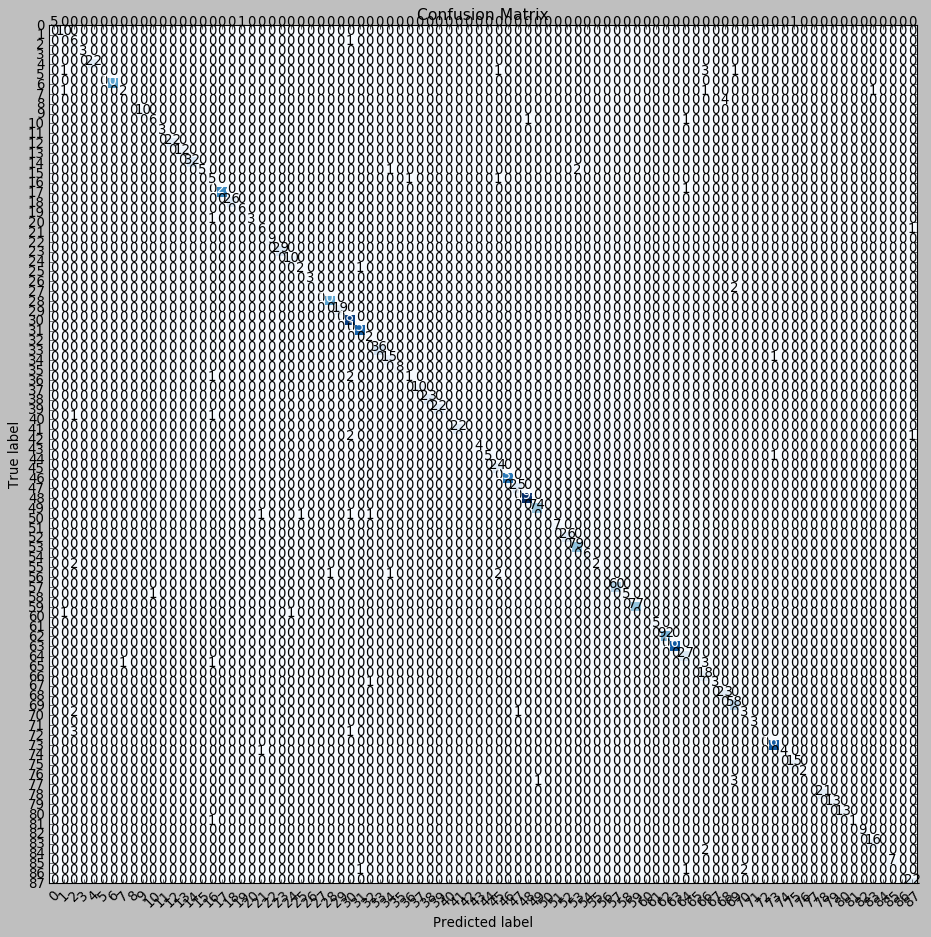

In [32]:
plt.style.use('classic')
plt.figure(figsize=(14,14))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train,prediction_train, classes= list(range(88)),normalize=False, title='Confusion Matrix')

### Load and launch 

In [3]:
vector = pickle.load(open('vector.pkl','rb'))
encoded_y = pickle.load(open('encoded_y.pkl','rb'))
mileage_df = pickle.load(open('mileage.pkl','rb'))
x, x_test_final, y, y_test_final = train_test_split(vector, encoded_y, test_size=0.1, random_state=44)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,  random_state=44)

some_input ='ON DECEMBER 4, 2019, A COLONIAL OPERATOR NOTED THAT TANK 1465 MIGHT BE EXPERIENCING A LEAK IN THE TANK FLOOR WITH PRODUCT MIGRATING TOWARDS THE VICINITY OF THE CHINE (BOTTOM EXTENSION). THE CHINE (BOTTOM EXTENSION) IS THE FLAT STEEL PERIMETER FLOOR PLATE, WHICH EXTENDS UNDER THE SHELL AND OUTSIDE OF THE TANK, RESTING ON THE CONCRETE RINGWALL FOUNDATION. UPON FURTHER INVESTIGATION, A GASOLINE LEAK WAS CONFIRMED AT 1710 CENTRAL TIME. IT WAS DETERMINED THAT GASOLINE WAS SEEPING FROM UNDER THE TANK. THE PRODUCT WAS CONTAINED WITHIN THE TANK DIKE. ADDITIONALLY, CONTAINMENT BOOM WAS PLACED WITHIN THE DIKE AREA.    ON DECEMBER 4, 2019, 1804 CENTRAL TIME, A TELEPHONIC NRC REPORT (NRC#1265544) WAS MADE WITH AN ESTIMATED QUANTITY OF 1 BBL. RELEASED. THE NRC REPORT WAS MADE DUE TO THE DETERMINATION THAT ESTIMATED COSTS ASSOCIATED WITH THE RELEASE WOULD EXCEED $50,000.     ON DECEMBER 6, 2019, 1612 CENTRAL TIME, A TELEPHONIC 48-HOUR NRC UPDATE (NRC#1265714) WAS PROVIDED WITH AN UPDATE OF THE FOLLOWING INFORMATION:  THE TANK WAS EMPTIED OF PRODUCT ON DECEMBER 4, 2019, 2158 CENTRAL TIME AND TAKEN OUT OF SERVICE (OOS), THEREBY ELIMINATING THE LEAK SOURCE. THERE WAS NO CHANGE REPORTED WITH REGARD TO THE ESTIMATED RELEASE QUANTITY OF 1 BBL.      COLONIAL IS CONDUCTING AN INCIDENT ANALYSIS (IA) TO DETERMINE THE CAUSE OF THE FAILURE. COLONIAL PERSONNEL ARE EVALUATING APPROPRIATE INSPECTION METHODOLOGIES TO INVESTIGATING BOTH THE TANK FLOOR AND TANK INTERIOR. THE TANK REMAINS OOS AT THIS TIME.      COLONIAL ENVIRONMENTAL PERSONNEL CONTINUE TO CONDUCT ENVIRONMENTAL ANALYSIS TO AID IN ANY ASSOCIATED REMEDIAL ACTIONS.'
TFIDF = pickle.load(open('TFIDF.pkl','rb'))
label_encoder_y = pickle.load(open('label_encoder_y.pkl','rb'))

model_rf = pickle.load(open('model_rf.pkl','rb'))
model_rf_input = model_rf.predict_proba(TFIDF.transform([some_input]))

json_file = open('model_nn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nn = model_from_json(loaded_model_json)
# load weights into new model
model_nn.load_weights("model_nn.h5")
print("Loaded model from disk")
opt = SGD(lr=0.1, momentum=0.9, decay=0.001)
model_nn.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])
model_nn_input = model_nn.predict(TFIDF.transform([some_input]))

json_file = open('model_ensemble.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ensemble = model_from_json(loaded_model_json)
# load weights into new model
model_ensemble.load_weights("model_ensemble.h5")
print("Loaded model_ensemble from disk")
model_ensemble.compile(optimizer = opt, loss='sparse_categorical_crossentropy' ,  metrics=['accuracy'])

concated = []
concated.append(np.concatenate((model_nn_input, model_rf_input), axis=1))
concated = np.asarray(concated)
concated = np.reshape(concated, (concated.shape[0], concated.shape[2]))

label_encoder_y.inverse_transform(np.argsort(model_ensemble.predict(concated), axis=1)[:,-1:][0])[0]

Loaded model from disk
Loaded model_ensemble from disk


'colonial '

### accuracy of top k companies

In [6]:
#this code finds probability that model recommends a company in top 10 that is actually the target for failure.
count_best = 0
top = 10

for i in range(len(y_test_final)):
    some_input = x_test_final[i]
    y_output = label_encoder_y.inverse_transform([y_test_final[i]])
    model_rf_input = model_rf.predict_proba(some_input)
    model_nn_input = model_nn.predict(some_input)
    concated = []
    concated.append(np.concatenate((model_nn_input, model_rf_input), axis=1))
    concated = np.asarray(concated)
    concated = np.reshape(concated, (concated.shape[0], concated.shape[2]))
    best_k = np.argsort(model_ensemble.predict(concated), axis=1)[:,0:top][0]
    best = []
    for j in range(top):
        best.append(label_encoder_y.inverse_transform([best_k[j]])[0])
    if y_output in best:
        count_best +=1
print('probability of the target worst company be among the top 10 recommended:',round(count_best/len(y_test_final), 4))

probability of the target worst company be among the top 10 recommended: 0.0053
